In [1]:
# Import libaries
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Import Modeling libraries
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

from surprise import BaselineOnly, Dataset, Reader, accuracy, SVD, SVDpp, NMF
from surprise.model_selection import GridSearchCV, train_test_split

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading user rating datasets
train_df = pd.read_csv('data/user_ratings_train.csv')
test_df = pd.read_csv('data/user_ratings_test.csv')
new_users_train_df = pd.read_csv('data/new_user_ratings_train.csv')
new_users_test_df = pd.read_csv('data/new_user_ratings_test.csv')

# Loading anime dataset
anime_df = pd.read_csv('./data/anime.csv')
anime_df.fillna({"genres": ""}, inplace=True)
anime_df.fillna({"synopsis": ""}, inplace=True)

In [3]:
anime_df.head()

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,52991,Sousou no Frieren,2023-09-29,2024-03-22,During their decade-long quest to defeat the D...,9.31,1.0,159,1044444,609185,tv,finished_airing,"Adventure,Drama,Fantasy,Shounen",28,fall,friday,23:00,manga,pg_13,Madhouse
1,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,2.0,3,3486975,2198350,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
2,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,3.0,14,2671014,1451230,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
3,38524,Shingeki no Kyojin Season 3 Part 2,2019-04-29,2019-07-01,Seeking to restore humanity's diminishing hope...,9.05,4.0,21,2411646,1673369,tv,finished_airing,"Action,Drama,Gore,Military,Shounen,Survival,Su...",10,spring,monday,00:10,manga,r,Wit Studio
4,60022,One Piece Fan Letter,2024-10-20,2024-10-20,Although the golden age of piracy is about to ...,9.05,5.0,2322,93088,70227,tv_special,finished_airing,"Action,Adventure,Fantasy,Shounen",1,fall,NaN,NaN,light_novel,pg_13,Toei Animation


### Adding new user's list from MyAnimeList to User Rating

In [4]:
# Client id 
def load_client_id(config_path = 'credentials.yml'):
    with open(config_path,'r') as file:
        config = yaml.safe_load(file)
    return config['api']['client_id']

client_id = load_client_id()

In [5]:
import requests
import time

CLIENT_ID = client_id   # ID to authenticate requests to the API

MY_ANIME_LIST_API_URL = 'https://api.myanimelist.net/v2' # The API endpoint that will be accessed.
API_REQUEST_DELAY = 1 # Delay to prevent over-use of the API

def get_users_list(username: str, new_user_id: int):
    """Collects anime lists and appends to an existing JSON file"""
    response: requests.Response = None
    try:
        response = requests.get(f"{MY_ANIME_LIST_API_URL}/users/{username}/animelist?fields=list_status&limit=1000",
                                headers={'X-MAL-CLIENT-ID': CLIENT_ID})
        time.sleep(API_REQUEST_DELAY * 2)

        user_anime_list = {"username": username, "anime_list": []}
        anime_list_data = response.json().get('data')
        if anime_list_data:
            for node in anime_list_data:
                user_anime_list["anime_list"].append({"anime": node["node"], "list_status": node["list_status"]})

        while response.json().get('paging', {}).get('next'):
            time.sleep(API_REQUEST_DELAY * 2)
            response = requests.get(response.json()['paging']['next'] + "&fields=list_status",
                                    headers={'X-MAL-CLIENT-ID': CLIENT_ID})
            anime_list_data = response.json().get('data')
            if anime_list_data:
                for node in anime_list_data:
                    user_anime_list["anime_list"].append(
                        {"anime": node["node"], "list_status": node["list_status"]})

        print(f"{ind}. Found {username}'s anime list. They watched {len(user_anime_list['anime_list'])} anime...")

    except Exception as e:
        print(f"Exception occurred while processing {username}: {e}")

    user_ratings_dict = {
        "user_id" : [],
        "anime_id" : [],
        "score" : []
    }

    for anime_rating in user_anime_list["anime_list"]:
        if anime_rating["list_status"].get("status") == "completed" and anime_df.id.isin([anime_rating["anime"]["id"]]).any():
             user_ratings_dict["user_id"].append(new_user_id)
             user_ratings_dict["anime_id"].append(anime_rating["anime"]["id"])
             user_ratings_dict["score"].append(anime_rating["list_status"]["score"])
    
    print("Finished writing user anime lists.")
    
    return pd.DataFrame(data= user_ratings_dict)

    

In [6]:
# get next user id
def get_next_user_id(user_ratings_df:pd.DataFrame):
    next_user_id = max(user_ratings_df.user_id.unique())+1
    return next_user_id

## Setup the Distance Functions

In [7]:
# cosine distane
def cosine_distance_metric(user_profile, anime_vector_df):
    user_vector_df = np.array([user_profile["weighted_vector_avg"]])
    dist_matrix = cosine_distances(user_vector_df, anime_vector_df).flatten()
    return dist_matrix

# euclidean distances
def euclidean_distances_metric(user_profile, anime_vector_df):
    user_vector_df = np.array([user_profile["weighted_vector_avg"]])
    dist_matrix = euclidean_distances(user_vector_df, anime_vector_df).flatten()
    return dist_matrix

# manhattan distances
def manhattan_distances_metric(user_profile, anime_vector_df):
    user_vector_df = np.array([user_profile["weighted_vector_avg"]])
    dist_matrix = manhattan_distances(user_vector_df, anime_vector_df).flatten()
    return dist_matrix

## Create Recommender System

### Content-Based Filtering Recommender

In [8]:
# Content-Based Filtering Recommender

class CBFRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame):
        self.anime_df = anime_data
        self.user_ratings_data = user_ratings_data
        self.users_to_ignore_on_evaluation = []
        self.custom_user_mappings = {}  # username: user_id

    # TF-IDF Vectorization of anime data
    def vectorize_anime_data(self, stop_words='english', max_features=50, max_df=0.5, min_df=0.01):
        vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df, min_df=min_df)
        vectors = vectorizer.fit_transform(self.anime_df['genres'])
        self.anime_vector_df = pd.DataFrame(vectors.toarray(), index=self.anime_df['id'])
        return self.anime_vector_df

    # Build the user's taste profile
    def create_user_profile(self, user_id: int):
        user_ratings = self.user_ratings_data[self.user_ratings_data['user_id'] == user_id]
        if user_ratings.empty:
            return None  # No ratings available for this user
        high_ratings = user_ratings[user_ratings.score >= user_ratings.score.mean()]
        anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(high_ratings['anime_id'])]
        if anime_vectors.empty:
            return None  # No vectors available for the rated anime
        return anime_vectors.mean()

    # Calculate distance between user profile and all anime
    def get_user_anime_distance(self, user_id: int, distance_metric='cosine'):
        user_profile = self.create_user_profile(user_id)
            
        metrics = {
            'cosine': cosine_distances,
            'euclidean': euclidean_distances,
            'manhattan': manhattan_distances
        }
        distance_func = metrics.get(distance_metric)
        if distance_func is None:
            raise ValueError(f'Invalid distance metric: {distance_metric}')
        distances = distance_func([user_profile], self.anime_vector_df.values).flatten()
        distance_df = pd.DataFrame({'anime_id': self.anime_vector_df.index, 'distance': distances})

        watched_ids = self.user_ratings_data[self.user_ratings_data.user_id == user_id]['anime_id']
        return distance_df[~distance_df.anime_id.isin(watched_ids)].sort_values('distance')

    # Recommend top N anime to user
    def recommend_user(self, user_id: int, num_recommendations=10, distance_metric='cosine', add_anime_info=True):
        recommendations = self.get_user_anime_distance(user_id, distance_metric).head(num_recommendations)
        if add_anime_info:
            recommendations = recommendations.merge(self.anime_df, left_on='anime_id', right_on='id')
        return recommendations

    # Return anime with their distance scores
    def get_user_anime_scores(self, user_id: int, distance_metric='cosine'):
        scores = self.get_user_anime_distance(user_id, distance_metric)
        return scores.rename(columns={'distance': 'score'})

    # Add a new user using a MyAnimeList username
    def add_new_user_by_mal_username(self, username: str):
        if username in self.custom_user_mappings:
            return self.custom_user_mappings[username]

        user_id = get_next_user_id(self.user_ratings_data)
        list_df = get_users_list(username, user_id)
        self.user_ratings_data = pd.concat([self.user_ratings_data, list_df])
        self.users_to_ignore_on_evaluation.append(user_id)
        self.custom_user_mappings[username] = user_id
        return user_id

    # Evaluate hit rate and mean reciprocal rank
    def evaluate(self, num_recommendations: int, testing_df: pd.DataFrame, distance_metric='cosine'):
        users = testing_df['user_id'].unique()
        hits, reciprocal_ranks = 0, []

        for user_id in users:
            if user_id in self.users_to_ignore_on_evaluation:
                continue
            recommendations = self.recommend_user(user_id, num_recommendations, distance_metric, add_anime_info=False)
            if recommendations.empty:
                continue  # Skip users with no recommendations

            recommendations = self.recommend_user(user_id, num_recommendations, distance_metric, add_anime_info=False)
            test_anime_ids = testing_df[testing_df.user_id == user_id]['anime_id'].values
            recommend_anime_ids = recommendations['anime_id'].values

            hit_positions = [i for i, anime_id in enumerate(recommend_anime_ids) if anime_id in test_anime_ids]
            if hit_positions:
                hits += 1
                reciprocal_ranks.append(1 / (hit_positions[0] + 1))

        total_users = len(users)
        return {
            "hit_rate": hits / total_users,
            "mean_reciprocal_rank": np.mean(reciprocal_ranks) if reciprocal_ranks else 0
        }

    # Make recommendations for all the users
    def make_recommendations(self, testing_df: pd.DataFrame, num_recommendations=20, distance_metric='cosine'):
        users = testing_df['user_id'].unique()  # FIXED: was wrongly typed as "testings_df"
        recs = {}

        for user_id in users:
            actual_animes = self.anime_vector_df.loc[
                self.anime_vector_df.index.isin(testing_df[testing_df.user_id == user_id]['anime_id'])
            ]
            if len(actual_animes) > 0:
                predictions = self.recommend_user(user_id, num_recommendations, distance_metric, add_anime_info=False)
                prediction_vectors = self.anime_vector_df.loc[
                    self.anime_vector_df.index.isin(predictions['anime_id'])
                ]
                recs[user_id] = {
                    "actual_anime_vectors": actual_animes.to_numpy(),
                    "predictions": predictions,
                    "prediction_vectors": prediction_vectors.to_numpy()
                }
            else:
                print(f"Warning: Not enough anime vectors for user {user_id}")

        return recs

### Create the Collaborative Filtering Recommender

In [9]:
# convert user ratings DataFrame into a format compatible with the Surprise library for collaborative filtering
def convert_user_ratings_to_surprise_dataset(ur_df):
    surprise_user_rating_df = ur_df[["user_id", "anime_id", "score"]]
    surprise_user_rating_df = surprise_user_rating_df.rename(columns={
        "user_id": "userID", 
        "anime_id": "itemID", 
        "score": "rating"
    })
    
    reader = Reader(rating_scale=(0, 10))
    data = Dataset.load_from_df(surprise_user_rating_df, reader)
    return data

In [10]:
# Collaborative Filtering Recommender

class CollaborativeFilteringRecommender:
    def __init__(self, ratings_dataset: pd.DataFrame, mf_algorithm=SVD):
        # Save the ratings and algorithm
        self.ratings_dataset = ratings_dataset
        self.mf_algorithm = mf_algorithm      # matrix factorization model to use (default is SVD).    

        # User tracking
        self.custom_user_mappings = {}
        self.users_to_ignore_on_evaluation = []

        # Train model
        self._fit_model()

    def _fit_model(self):
        # Convert ratings to Surprise format and train the model
        data = convert_user_ratings_to_surprise_dataset(self.ratings_dataset)
        self.cf_trainset = data.build_full_trainset()
        self.cf_model = self.mf_algorithm()
        self.cf_model.fit(self.cf_trainset)

    def _get_unrated_items(self, inner_user_id):
        # Get items the user hasn't rated yet
        rated = {iid for (iid, _) in self.cf_trainset.ur[inner_user_id]}
        return [iid for iid in self.cf_trainset.all_items() if iid not in rated]

    def get_user_anime_scores(self, user_id: str):
        # Predict scores for all anime the user hasn't rated yet
        inner_id = self.cf_trainset.to_inner_uid(user_id)
        predictions = [
            self.cf_model.predict(user_id, self.cf_trainset.to_raw_iid(iid))
            for iid in self._get_unrated_items(inner_id)
        ]
        return pd.DataFrame({
            'id': [int(p.iid) for p in predictions],
            'score': [p.est for p in predictions]
        })

    def recommend_user(self, inner_user_id, num_recommendations):
        # Recommend top N anime for a user
        user_id = self.cf_trainset.to_raw_uid(inner_user_id)
        predictions = [
            self.cf_model.predict(user_id, self.cf_trainset.to_raw_iid(iid))
            for iid in self._get_unrated_items(inner_user_id)
        ]
        top_n = sorted(predictions, key=lambda p: p.est, reverse=True)[:num_recommendations]
        return [int(p.iid) for p in top_n]

    def add_new_user_by_mal_username(self, username: str):
        # Add new user ratings and retrain model
        if username in self.custom_user_mappings:
            return self.custom_user_mappings[username]

        user_id = get_next_user_id(self.ratings_dataset)
        user_ratings = get_users_list(username, user_id)

        self.custom_user_mappings[username] = user_id
        self.users_to_ignore_on_evaluation.append(user_id)
        self.ratings_dataset = pd.concat([self.ratings_dataset, user_ratings])

        print("Refitting model...")
        self._fit_model()
        print("Model retrained.")

        return user_id

    def evaluate(self, num_recommendations: int, testing_df: pd.DataFrame):
        # Evaluate using Hit Rate and Mean Reciprocal Rank (MRR)
        hits, mrr_sum, tested_users = 0, 0, 0

        for inner_id in self.cf_trainset.all_users():
            user_id = int(self.cf_trainset.to_raw_uid(inner_id))
            if user_id in self.users_to_ignore_on_evaluation:
                continue

            recommendations = self.recommend_user(inner_id, num_recommendations)
            actual = testing_df[testing_df.user_id == user_id]['anime_id'].tolist()

            for rank, anime_id in enumerate(recommendations):
                if anime_id in actual:
                    hits += 1
                    mrr_sum += 1 / (rank + 1)
                    break

            tested_users += 1

        return {
            "hit_rate": hits / tested_users if tested_users else 0,
            "mean_reciprocal_rank": mrr_sum / tested_users if tested_users else 0
        }

    def get_user_recommendations_df(self, user_recommendations: list):
        # Convert recommended anime IDs to full anime details
        return anime_df[anime_df.id.isin(user_recommendations)]

    def make_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df):
        # Return recommendation vectors for each user
        recommendations = {}

        for inner_id in self.cf_trainset.all_users():
            user_id = int(self.cf_trainset.to_raw_uid(inner_id))
            actual_ids = test_ratings_df[test_ratings_df.user_id == user_id]['anime_id']

            actual_vectors = anime_vector_df.loc[anime_vector_df.index.isin(actual_ids)]
            predicted_ids = self.recommend_user(inner_id, num_recommendations)
            predicted_vectors = anime_vector_df.loc[anime_vector_df.index.isin(predicted_ids)]

            if predicted_vectors.empty:
                print(f"No predicted anime vectors found for user {user_id}.")

            recommendations[user_id] = {
                "actual_anime_vectors": actual_vectors.to_numpy(),
                "predictions": predicted_ids,
                "prediction_vectors": predicted_vectors.to_numpy()
            }

        return recommendations

### Create the Hybrid Filtering Recommender

In [32]:
# HybridRecommender Filtering Recommender

class HybridRecommender:
    def __init__(self, anime_data, user_ratings_data, cbf_distance_metric='cosine'):
        # Initialize content-based and collaborative recommenders
        self.anime_data = anime_data
        self.user_ratings_data = user_ratings_data
        self.cbf_distance_metric = cbf_distance_metric
        self.users_to_ignore_on_evaluation = []

        self.cbf_recommender = CBFRecommender(anime_data, user_ratings_data)
        self.cbf_recommender.vectorize_anime_data()

        self.cf_recommender = CollaborativeFilteringRecommender(user_ratings_data)

    def get_user_combined_scores(self, user_id, alpha=0.6):
        # Get scores from CBF
        cbf_scores = self.cbf_recommender.get_user_anime_scores(user_id, distance_metric=self.cbf_distance_metric)
        cbf_scores.rename(columns={"score": "cbf_score", "anime_id": "id"}, inplace=True)
        cbf_scores['cbf_score'] = (cbf_scores['cbf_score'] - cbf_scores['cbf_score'].min()) / (cbf_scores['cbf_score'].max() - cbf_scores['cbf_score'].min())
    
        # Get scores from CF
        cf_scores = self.cf_recommender.get_user_anime_scores(user_id)
        cf_scores['cf_score'] = 1 - ((cf_scores['score'] - cf_scores['score'].min()) / (cf_scores['score'].max() - cf_scores['score'].min()))
        cf_scores.drop(columns=['score'], inplace=True)
    
        # Merge with outer join and fill missing
        combined = pd.merge(cbf_scores, cf_scores, on='id', how='outer')
        combined.fillna(1.0, inplace=True)
    
        # Final combined score with weight
        combined['combined_score'] = alpha * combined['cbf_score'] + (1 - alpha) * combined['cf_score']
    
        return combined.sort_values(by='combined_score')

    def recommend_user(self, user_id, num_recommendations):
        # Return top N recommendations for a user
        scores = self.get_user_combined_scores(user_id)
        return scores.head(num_recommendations)

    def add_new_user_by_mal_username(self, username):
        # Add a new user to both systems
        cbf_id = self.cbf_recommender.add_new_user_by_mal_username(username)
        cf_id = self.cf_recommender.add_new_user_by_mal_username(username)

        if cbf_id != cf_id:
            print(f"Warning: Mismatched user IDs ({cbf_id} != {cf_id})")

        self.users_to_ignore_on_evaluation.append(cf_id)
        return cf_id

    def get_user_anime_recommendations_df(self, recommendations_df):
        # Return full anime info for given recommendations
        return anime_df[anime_df.id.isin(recommendations_df.id)]

    def evaluate(self, num_recommendations, test_df):
        # Evaluate model using Hit Rate and Mean Reciprocal Rank
        hits = 0
        mrr_sum = 0
        user_ids = test_df['user_id'].unique()

        for user_id in user_ids:
            if user_id in self.users_to_ignore_on_evaluation:
                continue

            recommendations = self.recommend_user(user_id, num_recommendations)
            actual = test_df[test_df.user_id == user_id]['anime_id'].values

            for rank, anime_id in enumerate(recommendations.id):
                if anime_id in actual:
                    hits += 1
                    mrr_sum += 1 / (rank + 1)
                    break

        total = len(user_ids)
        return {
            "hit_rate": hits / total if total else 0,
            "mean_reciprocal_rank": mrr_sum / total if total else 0
        }

    def make_recommendations(self, num_recommendations, test_df, anime_vector_df):
        # Generate recommendations for all users
        results = {}

        for user_id in self.user_ratings_data['user_id'].unique():
            recs = self.recommend_user(user_id, num_recommendations)
            actual = test_df[test_df.user_id == user_id]['anime_id']

            results[user_id] = {
                "actual_anime_vectors": anime_vector_df.loc[anime_vector_df.index.isin(actual)].to_numpy(),
                "predictions": recs,
                "prediction_vectors": anime_vector_df.loc[anime_vector_df.index.isin(recs['id'])].to_numpy()
            }

        return results

In [42]:
# std_anime_hybrid_recommender = HybridRecommender(anime_df, train_df)
# std_anime_hybrid_recommender.get_user_combined_scores(277)

### Evaluation

In [13]:
# define the distance meric to use for minimum distance evaluation
eval_dist_metric = 'cosine'

#### Evaluating Content - Based Recommeners

In [14]:
# Standard dataset

std_cbf_recommender = CBFRecommender(anime_df,train_df)
std_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
id,,,,,,,,,,,,,,,,,,,,,
52991,0.000000,0.0,0.464844,0.0,0.0,0.0,0.0,0.0,0.0,0.521163,...,0.0,0.582935,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5114,0.322780,0.0,0.351660,0.0,0.0,0.0,0.0,0.0,0.0,0.394266,...,0.0,0.440997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9253,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.354602,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.566149,0.0
38524,0.297920,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.363900,...,0.0,0.407032,0.0,0.0,0.0,0.0,0.0,0.0,0.580995,0.0
60022,0.447164,0.0,0.487172,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.610935,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60470,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
60857,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
57969,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [15]:
std_cbf_recommender_evaluation = {
    "5" : std_cbf_recommender.evaluate(5, test_df),
    "10": std_cbf_recommender.evaluate(10, test_df),
    "20": std_cbf_recommender.evaluate(20, test_df)
}
std_cbf_recommender_evaluation

{'5': {'hit_rate': 0.08528120130330075,
  'mean_reciprocal_rank': 0.4845238095238095},
 '10': {'hit_rate': 0.15370449072106532,
  'mean_reciprocal_rank': 0.3264538073293834},
 '20': {'hit_rate': 0.26887661141804786,
  'mean_reciprocal_rank': 0.2159000705816321}}

In [16]:
# New Users Dataset

new_cbf_recommender = CBFRecommender(anime_df, new_users_train_df)
new_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
id,,,,,,,,,,,,,,,,,,,,,
52991,0.000000,0.0,0.464844,0.0,0.0,0.0,0.0,0.0,0.0,0.521163,...,0.0,0.582935,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5114,0.322780,0.0,0.351660,0.0,0.0,0.0,0.0,0.0,0.0,0.394266,...,0.0,0.440997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9253,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.354602,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.566149,0.0
38524,0.297920,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.363900,...,0.0,0.407032,0.0,0.0,0.0,0.0,0.0,0.0,0.580995,0.0
60022,0.447164,0.0,0.487172,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.610935,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60470,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
60857,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
57969,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [17]:
new_cbf_recommender.recommend_user(np.random.choice(new_users_train_df.user_id), 5)

,anime_id,distance,id,title,start_date,end_date,synopsis,score,rank,popularity,...,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,2926,0.0626,2926,Myself; Yourself,2007-10-03,2007-12-26,"In the peaceful little town of Sakuranomori, a...",7.10,3915.0,1349,...,tv,finished_airing,"Drama,Romance,School",13,fall,wednesday,02:15,visual_novel,pg_13,Doga Kobo
1,48875,0.0626,48875,Dahuoji Yu Gongzhu Qun,2021-08-08,2021-10-24,"Zhu Yun's university life just began, but it w...",6.65,6185.0,11258,...,ona,finished_airing,"Drama,Romance,School",13,summer,NaN,NaN,novel,pg_13,2:10 Animation
2,59845,0.0626,59845,Kaoru Hana wa Rin to Saku,2025,NaN,"Despite being adjacent to one another, Chidori...",NaN,NaN,3561,...,tv,not_yet_aired,"Drama,Romance,School",0,NaN,NaN,NaN,web_manga,NaN,CloverWorks
3,30015,0.0626,30015,ReLIFE,2016-07-02,2016-09-24,Dismissed as a hopeless loser by those around ...,7.96,714.0,151,...,tv,finished_airing,"Drama,Romance,School",13,summer,saturday,00:00,web_manga,pg_13,TMS Entertainment
4,37044,0.0626,37044,Guomin Laogong Dai Huijia 2nd season,2017-05-01,2017-07-03,,6.30,8252.0,8059,...,ona,finished_airing,"Drama,Romance,School",12,spring,NaN,NaN,novel,pg_13,B.CMAY PICTURES


In [18]:
new_cbf_recommender_evaluation = {
    "5" : new_cbf_recommender.evaluate(5, new_users_test_df),
    "10": new_cbf_recommender.evaluate(10, new_users_test_df),
    "20": new_cbf_recommender.evaluate(20, new_users_test_df)
}
new_cbf_recommender_evaluation

{'5': {'hit_rate': 0.052125100240577385,
  'mean_reciprocal_rank': 0.5214285714285715},
 '10': {'hit_rate': 0.07698476343223737,
  'mean_reciprocal_rank': 0.3955800028344671},
 '20': {'hit_rate': 0.11398785657005385,
  'mean_reciprocal_rank': 0.28931682072545056}}

#### Evaluating Collaborative Recommenders

In [19]:
# Standard users Dataset

std_cf_recommender = CollaborativeFilteringRecommender(train_df)

In [20]:
std_cf_recommender_evaluation = {
    "5" : std_cf_recommender.evaluate(5, test_df),
    "10": std_cf_recommender.evaluate(10, test_df),
    "20": std_cf_recommender.evaluate(20, test_df)
}
std_cf_recommender_evaluation

{'5': {'hit_rate': 0.368182462105114,
  'mean_reciprocal_rank': 0.22253152004533197},
 '10': {'hit_rate': 0.4972375690607735,
  'mean_reciprocal_rank': 0.2397498296669551},
 '20': {'hit_rate': 0.6200594985125372,
  'mean_reciprocal_rank': 0.24835211238379795}}

In [21]:
# New Users Dataset

new_cf_recommender = CollaborativeFilteringRecommender(new_users_train_df)

In [22]:
new_cf_recommender_evaluation = {
    "5" : new_cf_recommender.evaluate(5, new_users_test_df),
    "10": new_cf_recommender.evaluate(10, new_users_test_df),
    "20": new_cf_recommender.evaluate(20, new_users_test_df)
}
new_cf_recommender_evaluation

{'5': {'hit_rate': 0.05842593653339443,
  'mean_reciprocal_rank': 0.02918432810172987},
 '10': {'hit_rate': 0.09210677053499829,
  'mean_reciprocal_rank': 0.03362741782091074},
 '20': {'hit_rate': 0.13999312636040784,
  'mean_reciprocal_rank': 0.03686654295095526}}

#### Evaluating Hybrid Recommeners

In [34]:
# Standard Users Dataset

std_hybrid_recommender = HybridRecommender(anime_df, train_df)

In [35]:
std_hybrid_recommender_evaluation = {
    "5" : std_hybrid_recommender.evaluate(5, test_df),
    "10": std_hybrid_recommender.evaluate(10, test_df),
    "20": std_hybrid_recommender.evaluate(20, test_df)
}
std_hybrid_recommender_evaluation

{'5': {'hit_rate': 0.36577418897860886,
  'mean_reciprocal_rank': 0.21393020730037357},
 '10': {'hit_rate': 0.5041790621901119,
  'mean_reciprocal_rank': 0.23238604550759198},
 '20': {'hit_rate': 0.6394673466496671,
  'mean_reciprocal_rank': 0.24178961269252652}}

In [36]:
# New Users Dataset

new_hybrid_recommender = HybridRecommender(anime_df, new_users_train_df)

In [37]:
new_hybrid_recommender_evaluation = {
    "5" : new_hybrid_recommender.evaluate(5, new_users_test_df),
    "10": new_hybrid_recommender.evaluate(10, new_users_test_df),
    "20": new_hybrid_recommender.evaluate(20, new_users_test_df)
}
new_hybrid_recommender_evaluation

{'5': {'hit_rate': 0.09852216748768473,
  'mean_reciprocal_rank': 0.06218543552144179},
 '10': {'hit_rate': 0.1356398212853706,
  'mean_reciprocal_rank': 0.06703198788202809},
 '20': {'hit_rate': 0.18490090502921297,
  'mean_reciprocal_rank': 0.0703972482682031}}

### Comparing the recommenders

#### For Standard/Normal Users

Hit Rate Comparison

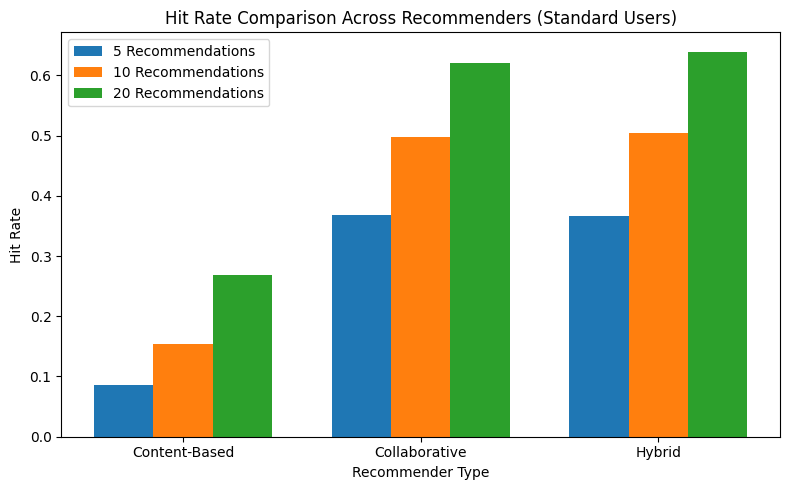

In [38]:
# Recommender system names
labels = ['Content-Based', 'Collaborative', 'Hybrid']

# Hit rates for each number of recommendations (5, 10, 20)
hit_rates = {
    "5": [std_cbf_recommender_evaluation["5"]["hit_rate"],
          std_cf_recommender_evaluation["5"]["hit_rate"],
          std_hybrid_recommender_evaluation["5"]["hit_rate"]],
    
    "10": [std_cbf_recommender_evaluation["10"]["hit_rate"],
           std_cf_recommender_evaluation["10"]["hit_rate"],
           std_hybrid_recommender_evaluation["10"]["hit_rate"]],
    
    "20": [std_cbf_recommender_evaluation["20"]["hit_rate"],
           std_cf_recommender_evaluation["20"]["hit_rate"],
           std_hybrid_recommender_evaluation["20"]["hit_rate"]]
}

x = np.arange(len(labels))  # positions for bars
bar_width = 0.25            # width of each bar
plt.figure(figsize=(8, 5))

# Draw a group of bars for each recommendation size
for i, (k, rates) in enumerate(hit_rates.items()):
    plt.bar(x + i * bar_width, rates, width=bar_width, label=f"{k} Recommendations")

# Labeling and layout
plt.xticks(x + bar_width, labels)
plt.xlabel("Recommender Type")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Comparison Across Recommenders (Standard Users)")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("data/hit_rate_normal_users.png", dpi=300)
plt.show()

Mean Reciprocal Rank Comparison

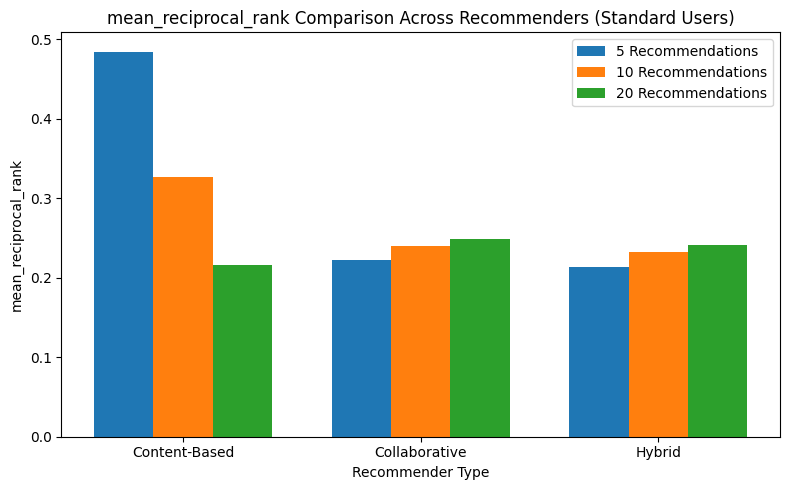

In [39]:
# Recommender system names
labels = ['Content-Based', 'Collaborative', 'Hybrid']

# Hit rates for each number of recommendations (5, 10, 20)
hit_rates = {
    "5": [std_cbf_recommender_evaluation["5"]["mean_reciprocal_rank"],
          std_cf_recommender_evaluation["5"]["mean_reciprocal_rank"],
          std_hybrid_recommender_evaluation["5"]["mean_reciprocal_rank"]],
    
    "10": [std_cbf_recommender_evaluation["10"]["mean_reciprocal_rank"],
           std_cf_recommender_evaluation["10"]["mean_reciprocal_rank"],
           std_hybrid_recommender_evaluation["10"]["mean_reciprocal_rank"]],
    
    "20": [std_cbf_recommender_evaluation["20"]["mean_reciprocal_rank"],
           std_cf_recommender_evaluation["20"]["mean_reciprocal_rank"],
           std_hybrid_recommender_evaluation["20"]["mean_reciprocal_rank"]]
}

x = np.arange(len(labels))  # positions for bars
bar_width = 0.25            # width of each bar
plt.figure(figsize=(8, 5))

# Draw a group of bars for each recommendation size
for i, (k, rates) in enumerate(hit_rates.items()):
    plt.bar(x + i * bar_width, rates, width=bar_width, label=f"{k} Recommendations")

# Labeling and layout
plt.xticks(x + bar_width, labels)
plt.xlabel("Recommender Type")
plt.ylabel("mean_reciprocal_rank")
plt.title("mean_reciprocal_rank Comparison Across Recommenders (Standard Users)")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("data/mean_reciprocal_rank_normal_users.png", dpi=300)
plt.show()

#### For New Users

Hit Rate Comparison

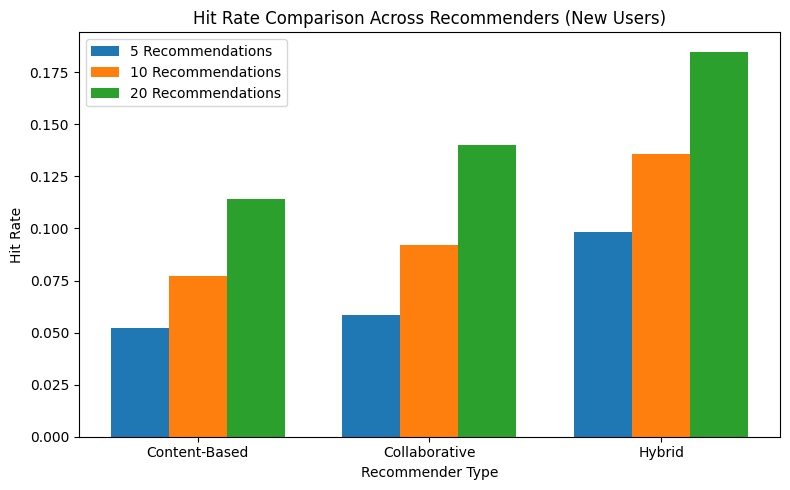

In [40]:
# Recommender system names
labels = ['Content-Based', 'Collaborative', 'Hybrid']

# Hit rates for each number of recommendations (5, 10, 20)
hit_rates = {
    "5": [new_cbf_recommender_evaluation["5"]["hit_rate"],
          new_cf_recommender_evaluation["5"]["hit_rate"],
          new_hybrid_recommender_evaluation["5"]["hit_rate"]],
    
    "10": [new_cbf_recommender_evaluation["10"]["hit_rate"],
           new_cf_recommender_evaluation["10"]["hit_rate"],
           new_hybrid_recommender_evaluation["10"]["hit_rate"]],
    
    "20": [new_cbf_recommender_evaluation["20"]["hit_rate"],
           new_cf_recommender_evaluation["20"]["hit_rate"],
           new_hybrid_recommender_evaluation["20"]["hit_rate"]]
}

x = np.arange(len(labels))  # positions for bars
bar_width = 0.25            # width of each bar
plt.figure(figsize=(8, 5))

# Draw a group of bars for each recommendation size
for i, (k, rates) in enumerate(hit_rates.items()):
    plt.bar(x + i * bar_width, rates, width=bar_width, label=f"{k} Recommendations")

# Labeling and layout
plt.xticks(x + bar_width, labels)
plt.xlabel("Recommender Type")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Comparison Across Recommenders (New Users)")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("data/hit_rate_new_users.png", dpi=300)

Mean Reciprocal Rank Comparison

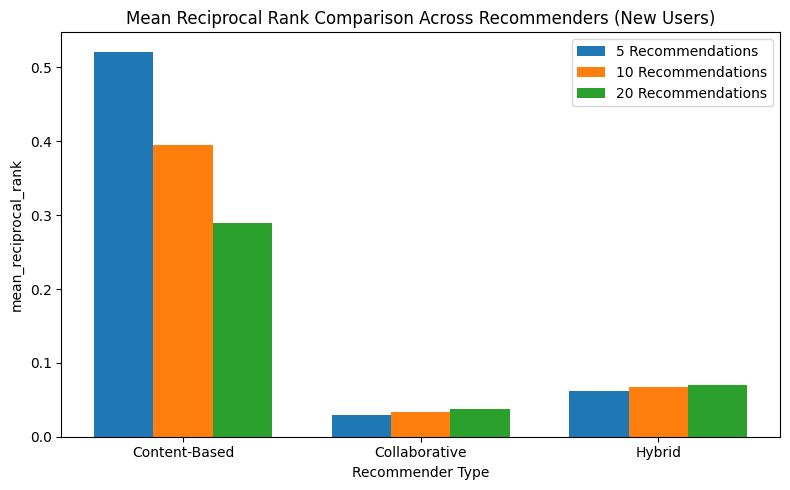

In [41]:
# Recommender system names
labels = ['Content-Based', 'Collaborative', 'Hybrid']

# Hit rates for each number of recommendations (5, 10, 20)
hit_rates = {
    "5": [new_cbf_recommender_evaluation["5"]["mean_reciprocal_rank"],
          new_cf_recommender_evaluation["5"]["mean_reciprocal_rank"],
          new_hybrid_recommender_evaluation["5"]["mean_reciprocal_rank"]],
    
    "10": [new_cbf_recommender_evaluation["10"]["mean_reciprocal_rank"],
           new_cf_recommender_evaluation["10"]["mean_reciprocal_rank"],
           new_hybrid_recommender_evaluation["10"]["mean_reciprocal_rank"]],
    
    "20": [new_cbf_recommender_evaluation["20"]["mean_reciprocal_rank"],
           new_cf_recommender_evaluation["20"]["mean_reciprocal_rank"],
           new_hybrid_recommender_evaluation["20"]["mean_reciprocal_rank"]]
}

x = np.arange(len(labels))  # positions for bars
bar_width = 0.25            # width of each bar
plt.figure(figsize=(8, 5))

# Draw a group of bars for each recommendation size
for i, (k, rates) in enumerate(hit_rates.items()):
    plt.bar(x + i * bar_width, rates, width=bar_width, label=f"{k} Recommendations")

# Labeling and layout
plt.xticks(x + bar_width, labels)
plt.xlabel("Recommender Type")
plt.ylabel("mean_reciprocal_rank")
plt.title("Mean Reciprocal Rank Comparison Across Recommenders (New Users)")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("data/mean_reciprocal_rank_new_users.png", dpi=300)

### Save the Recommenders and Hit Rates

In [43]:
import pickle

def write_object(object_inst, file_name):
    with open(file_name, "wb") as fp:
        pickle.dump(object_inst, fp)

In [44]:
# Saving recommendation models

# Hybrid
write_object(std_hybrid_recommender, "data/hybrid_recommender")
write_object(new_hybrid_recommender, "data/new_hybrid_recommender")

# Collaborative
write_object(std_cf_recommender, "data/collaborative_recommender")
write_object(new_cf_recommender, "data/new_collaborative_recommender")

# Content-Based
write_object(std_cbf_recommender, "data/cbf_recommender")
write_object(new_cbf_recommender, "data/new_cbf_recommender")

In [45]:
# Saving Evaluation functions

# Hybrid
write_object(std_hybrid_recommender_evaluation, "data/hybrid_evaluation")
write_object(new_hybrid_recommender_evaluation, "data/new_hybrid_evaluation")
# Collaborative
write_object(std_cf_recommender_evaluation, "data/cf_evaluation")
write_object(new_cf_recommender_evaluation, "data/new_cf_evaluation")

# Content-Based
write_object(std_cbf_recommender_evaluation, "data/cbf_evaluation")
write_object(new_cbf_recommender_evaluation, "data/new_cbf_evaluation")